### DFRとVFRの未来の擾乱に対する計画収束速度で比較する

仮説: DFRで運行すると未来の擾乱に対する周りの人（自分の決定に影響を及ぼしうる人）の反応が瞬時にわかるため、VFRと比べた際に擾乱に対する収束速度が高まる。その結果として交通キャパシティが上昇する。

この仮説をシミュレーション実験によって確かめる。

#### 組むべき実験系
- ノイズは1個だけ（複数にも対応できるようにはしているが速度計算周りが怪しい）


In [71]:
import random
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import pandas as pd
import sys
import copy

sys.path.append("../")
from models import Cars, ReservationTable, DFRSimulation, VFRSimulation
from utils import check_multiple_noise_effect, validate_with_ttc

# ↑↑↑↑↑↑↑↑↑この部分は別セルでも良い↑↑↑↑↑↑↑↑↑

# 初期設定（独立変数群）
CAR_NUM = 50 #時間窓内の車の総数
START_TIME = 0
TOTAL_LENGTH = 1000 # 入り口から出口までの距離 [m]
WAYPOINTS_NUM = 10 #constrained way pointの数
MEAN_SPEED = 20 # 秒速[m/s]として定義
MAX_SPEED = 30 # 秒速[m/s]として定義
MAX_ACC = 3 # m/s^sで定義, maxは0.3gにした
TIME_STEP = 0.1
COMMUNICATION_SPEED = 0.1
TOTAL_TIME = 80
GLOBAL_TIME_WINDOW = 100  # Strategic Phaseでの時間幅
TTC = 2.5 #車間時間を暫定的に定義
DENSITY = 4.0 # 台数密度を車間時間として定義

def generate_arrival_times(car_num, d, TOTAL_TIME):
    sequence = [random.uniform(0, 3)]
    while len(sequence) < car_num:
        next_value = sequence[-1] + d + random.uniform(0, 2) + 0.2 # これは +0.2しておかないと入り口の時点で弾かれる場合がある
        sequence.append(next_value)
        if next_value > TOTAL_TIME:
            break
    return sequence

arrival_times = generate_arrival_times(CAR_NUM, DENSITY, TOTAL_TIME)
car_params = {"v_mean":MEAN_SPEED, "v_max": MAX_SPEED, "a_max":MAX_ACC, "a_min":MAX_ACC}


In [72]:
# 従属的に決まるもの
WAYPOINTS = [{"waypoint_idx": i, "x": TOTAL_LENGTH / WAYPOINTS_NUM * (i)} for i in range(WAYPOINTS_NUM+1)]
group_id = 0
arrival_times = [1.4273960210088035, 7.028347973663408, 11.639908408660311, 16.740031941643533, 22.015044642727, 26.416894484705946, 32.09182682366547, 37.22427821224153, 42.41397208767018, 47.78272557301472, 52.98630607163243, 58.139356970286, 62.882429004587024, 67.65920443074529, 72.54738662027125, 78.23343985655819, 82.76048010111138, 82.7]
arrival_times.append(TOTAL_TIME + TTC +0.2)

CARS = [Cars(arrival_time=time, index=index, v_mean=MEAN_SPEED, v_max = MAX_SPEED, a_max=MAX_ACC, a_min=MAX_ACC)
              for index, time in enumerate(arrival_times)]

In [73]:
reservation_table = ReservationTable(waypoints = WAYPOINTS, global_params = {"DESIRED_TTC":TTC})
# 各車がETAを決める部分

def register_initial_eta(cars):
    for idx, car in enumerate(CARS):
        desired_eta_list = car.create_desired_eta(WAYPOINTS)
        is_valid = reservation_table.validate(desired_eta_list)
        if is_valid:
            reservation_table.register(desired_eta_list)
        else:
            calibration_info = {"desired_list": desired_eta_list}
            calibrated_list, _ = reservation_table.calibrate_list(**calibration_info)
            # print(calibrated_list)
            # print()
            reservation_table.register(calibrated_list)
            car.my_list = calibrated_list

register_initial_eta(CARS)

In [74]:
# ここからDFRのシミュレーション
simulation = DFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, CARS = CARS, \
                          reservation_table = reservation_table)
simulation.conduct_simulation(should_plot=True)

Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

noise created!

t=1.5, next_car=1, current_noise= [{'x': [400, 430], 't': [20, 25]}], event_flg=arrival
carID: 0, Start:371.45207957982393, End:471.45207957982393
直接ノイズの影響を受けるもの: [0]
他の車の影響: []
対象車: [0]
t=1.5, car_id:0 avoiding noise.
avoidance by idx=0
{'x': [400, 430], 't': [20, 25]} True
18.5 3 30
eta: 16.48888888888889, 前の車に当たらない最速の時間:16.38888888888889, ノイズ開始:20
solve_acc_itinerary_early_avoid
==== START CREATING ETA====
acc_itinerary: [{'t_start': 1.5, 'acc': 3, 'v_0': 20, 't_end': 4.833333333333334}, {'t_start': 4.833333333333334, 'acc': 0, 'v_0': 30, 't_end': 10000000.0}]
ID: 0の新しいETA（Validate前） [{'waypoint_idx': 0, 'x': 0.0, 'eta': 1.4273960210088035, 'car_idx': 0, 'type': 'waypoint'}, {'waypoint_idx': 1, 'x': 100.0, 'eta': 5.388888888888888, 'car_idx': 0, 'type': 'waypoint'}, {'waypoint_idx': 2, 'x': 200.0, 'eta': 8.722222222222221, 'car_idx': 0, 'type': 'waypoint'}, {'waypoint_idx': 3, 'x': 300.0, 'eta': 12.055555555555554, 'car_idx': 0, 'type': 'waypoint'}, {'waypoint_idx': 

In [5]:
print(arrival_times)

[1.4273960210088035, 7.028347973663408, 11.639908408660311, 16.740031941643533, 22.015044642727, 26.416894484705946, 32.09182682366547, 37.22427821224153, 42.41397208767018, 47.78272557301472, 52.98630607163243, 58.139356970286, 62.882429004587024, 67.65920443074529, 72.54738662027125, 78.23343985655819, 82.76048010111138, 82.7]


### 続いて同じ条件でVFRを試す

arrival_timeやTTC、ノイズの発生タイミングはそのまま引き継ぐ. 


In [10]:
vfr_simulation = VFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, dfr_reference=simulation, car_params=car_params)

In [11]:
cars = vfr_simulation.CARS
car_1 = cars[1]
print(car_1.a_max)
print(vfr_simulation.TOTAL_TIME)

3
80


In [12]:
vfr_simulation.conduct_simulation(should_plot=True)

Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

noise created!
t=1.5, event_flg=arrival, noise=[{'x': [400, 430], 't': [20, 25]}]
t=7.1000000000000005, event_flg=arrival, noise=[{'x': [400, 430], 't': [20, 25]}]
t=11.700000000000001, event_flg=arrival, noise=[{'x': [400, 430], 't': [20, 25]}]
t=16.8, event_flg=arrival, noise=[{'x': [400, 430], 't': [20, 25]}]
t=22.1, event_flg=arrival, noise=[{'x': [400, 430], 't': [20, 25]}]
noise created!
t=26.5, event_flg=arrival, noise=[]
noise created!
noise created!
noise created!
noise created!
noise created!
noise created!
t=32.0, event_flg=noise created, noise=[{'x': [400, 430], 't': [37.0, 40.0]}]
t=32.1, event_flg=arrival, noise=[{'x': [400, 430], 't': [37.0, 40.0]}]
t=37.300000000000004, event_flg=arrival, noise=[{'x': [400, 430], 't': [37.0, 40.0]}]
noise created!
noise created!
t=42.5, event_flg=arrival, noise=[]
noise created!
noise created!
noise created!
noise created!
noise created!
t=47.800000000000004, event_flg=arrival, noise=[]
noise created!
t=48.0, event_flg=noise created, no

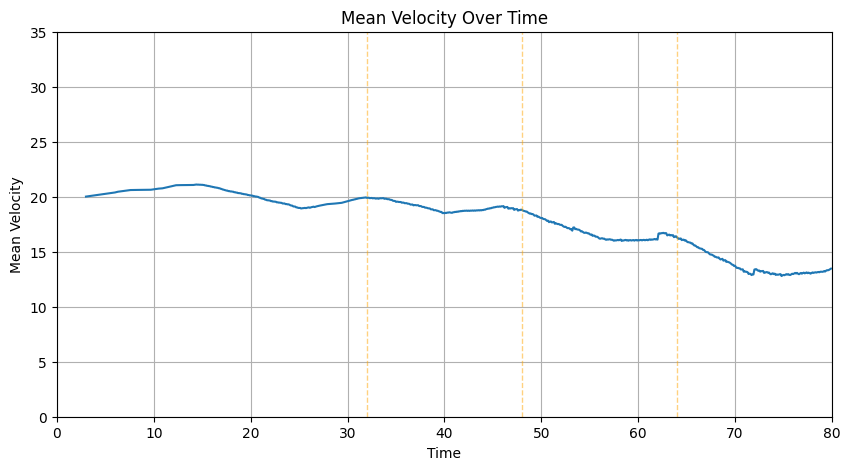

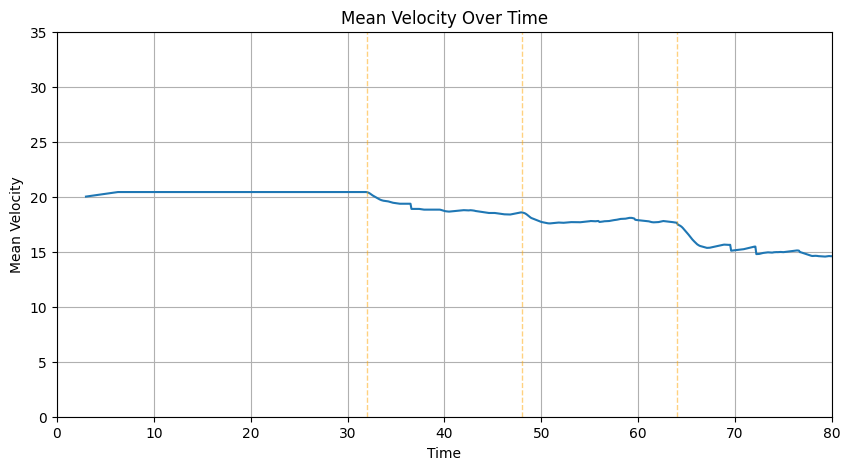

In [20]:
vfr_simulation.plot_v_mean_log("./images/vfr/v_mean_log_vfr.png")
simulation.plot_v_mean_log("./images/dfr/v_mean_log_dfr.png")

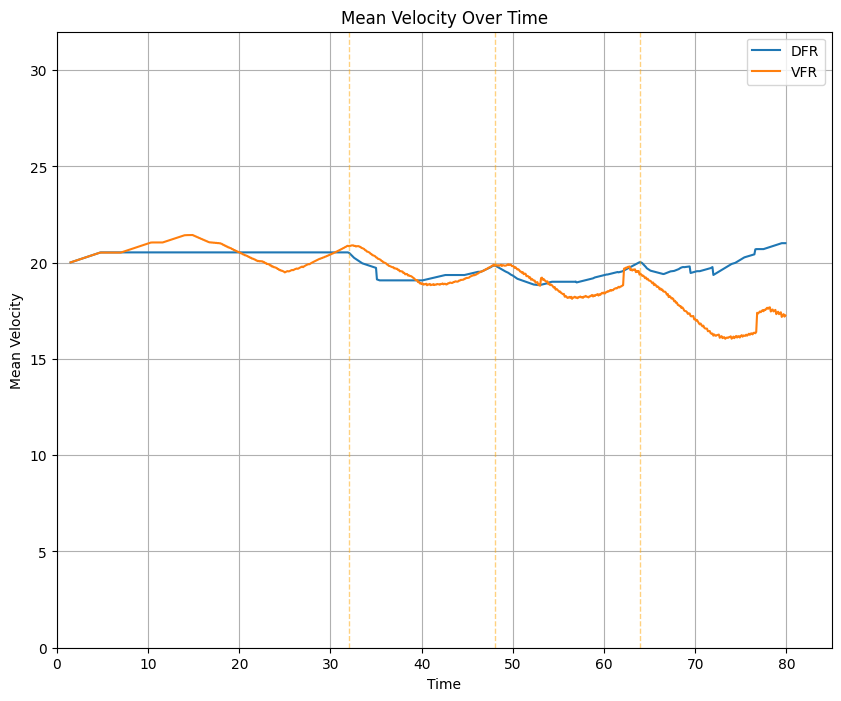

In [18]:
def plot_v_mean_log(path, v_mean_dfr, v_mean_vfr):
    v_mean_log = v_mean_dfr
    # event_flgが"noise"のデータポイントを抽出する
    noise_time = [entry["time"]
                  for entry in v_mean_log if entry.get("event_flg") == "noise"]
    noise_v_mean = [entry["v_mean"]
                    for entry in v_mean_log if entry.get("event_flg") == "noise"]
    noise_times = [entry["time"]
                   for entry in v_mean_vfr if entry.get("event_flg") == "noise"]

    # timeとv_meanをそれぞれリストに抽出する
    time = [entry["time"] for entry in v_mean_log]
    v_mean = [entry["v_mean"] for entry in v_mean_log]
    v_mean_vfr = [entry["v_mean"] for entry in v_mean_vfr]

    # グラフを描画する
    plt.figure(figsize=(10, 8))
    plt.plot(time, v_mean, label="DFR",)
    plt.plot(time, v_mean_vfr, label="VFR")

    # ノイズのデータポイントを赤丸でプロットする
    # plt.scatter(noise_time, noise_v_mean, color='red', label='Noise Event', zorder=5)

    # ノイズ発生タイミングに赤線
    for n in noise_times:
        plt.axvline(x=n, color='orange', linestyle='--', alpha=0.5,
                    linewidth=1)

    # グラフのタイトルとラベルを設定する
    plt.title('Mean Velocity Over Time')
    plt.xlabel('Time')
    plt.ylabel('Mean Velocity')

    plt.xlim(0, 85)
    plt.ylim(0, 32)
    plt.legend()

    # グリッドを表示する
    plt.grid(True)
    plt.savefig(path)

plot_v_mean_log("./images/dfr/v_mean_log_dfr_vs_vfr.png", simulation.v_mean_log, vfr_simulation.v_mean_log)

In [49]:
# Fundamental Diagram作るように一気にやるためのコードを書く. 
DENSITY_LIST = [20, 18, 16, 14, 12,10, 8,6,5,4,3.5, 3 ,2.8, 2.6, 2.5, 2]
results = []
arrival_time_log = []
import sys
import io
sys.stdout = original_stdout


def collect_v_mean_by_density(data):
    density_groups = defaultdict(list)
    for entry in data:
        density_groups[entry['density']].append(entry['v_mean'])
    
    # 各densityのv_meanの平均を計算
    density_mean_v_mean = {density: sum(v_means)/len(v_means) for density, v_means in density_groups.items()}
    return density_mean_v_mean


for idx, density in enumerate(DENSITY_LIST):
    print(f"d={density}")

    arrival_times = generate_arrival_times(CAR_NUM, density, TOTAL_TIME)
    arrival_times.append(TOTAL_TIME + TTC +0.2)
    CARS = [Cars(arrival_time=time, index=index, v_mean=MEAN_SPEED, v_max = MAX_SPEED, a_max=MAX_ACC, a_min=MAX_ACC)
              for index, time in enumerate(arrival_times)]
    arrival_time_log.append({"density": density, "arrival_times":arrival_times})

    # まずはDFR
    reservation_table = ReservationTable(waypoints = WAYPOINTS, global_params = {"DESIRED_TTC":TTC})
    register_initial_eta(CARS)
    # 標準出力を無効化
    original_stdout = sys.stdout
    sys.stdout = io.StringIO()

    dfr_simulation = DFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, CARS = CARS, \
                          reservation_table = reservation_table)
    result = {
        "type":"dfr",
        "density": density,
        "v_mean":None,
    }
    try:
        dfr_simulation.conduct_simulation(should_plot=False)
        dfr_log = dfr_simulation.v_mean_log
        v_mean_by_density = collect_v_mean_by_density(dfr_log)
        result["v_mean"] = v_mean_by_density
        
    except: 
        pass

    results.append(result)

    # 続いてVFR
    result = {
        "type":"vfr",
        "density": density,
        "v_mean":None,
    }
    try:
        vfr_simulation = VFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, dfr_reference=dfr_simulation, car_params=car_params)
        vfr_simulation.conduct_simulation(should_plot=False)
        vfr_log = vfr_simulation.v_mean_log
        v_mean_by_density = collect_v_mean_by_density(vfr_log)
        result["v_mean"] = v_mean_by_density
        
    except: 
        pass
    finally:
        # 標準出力を元に戻す
        sys.stdout = original_stdout
    results.append(result)
print("DONE!")


Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

d=20


Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

d=18


Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

d=16


Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

d=14


Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

d=12


Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

d=10


Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

d=8


Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

d=6


Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

d=5


Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

d=4


Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

d=3.5


Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

d=3


Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

d=2.8


Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

d=2.6


Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

d=2.5


Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

Simulation Progress:   0%|          | 0/800 [00:00<?, ?it/s]

d=2
DONE!


In [50]:
print(results)


[{'type': 'dfr', 'density': 20, 'v_mean': {0.006: 21.61651785714286, 0.005: 20.0, 0.004: 20.0}}, {'type': 'vfr', 'density': 20, 'v_mean': {0.006: 21.994707382706256, 0.005: 21.430845103714095, 0.004: 23.08744344933797}}, {'type': 'dfr', 'density': 18, 'v_mean': {0.007: 21.38558673469388, 0.006: 20.0, 0.005: 20.0}}, {'type': 'vfr', 'density': 18, 'v_mean': {0.007: 21.76235946441596, 0.006: 20.973410128443533, 0.005: 22.275954836392863}}, {'type': 'dfr', 'density': 16, 'v_mean': {0.007: 21.358801020408166, 0.006: 19.129127358490557, 0.005: 20.49999999999999}}, {'type': 'vfr', 'density': 16, 'v_mean': {0.007: 21.883259907993565, 0.006: 22.33370039405251, 0.005: 22.37308271337011, 0.004: 23.53599800616644}}, {'type': 'dfr', 'density': 14, 'v_mean': {0.008: 21.14040178571429, 0.007: 20.08490310950878, 0.006: 20.0}}, {'type': 'vfr', 'density': 14, 'v_mean': {0.008: 21.83537189680306, 0.007: 22.311010480506717, 0.006: 21.833944368596896, 0.005: 22.66010021418053}}, {'type': 'dfr', 'density': 

In [44]:
print(arrival_time_log)

[{'density': 16, 'arrival_times': [2.57974038768497, 19.15046296752963, 35.62277323547397, 53.425072171380904, 70.51843144668362, 88.6699885552426, 82.7]}, {'density': 8, 'arrival_times': [2.0275780112149135, 10.331682989033165, 19.836774715717983, 29.944829414982454, 39.52301137520881, 48.563067171228354, 57.46230398809321, 66.42996776278405, 74.87280038510644, 84.50275208708288, 82.7]}]


In [51]:
results_to_analyze = results

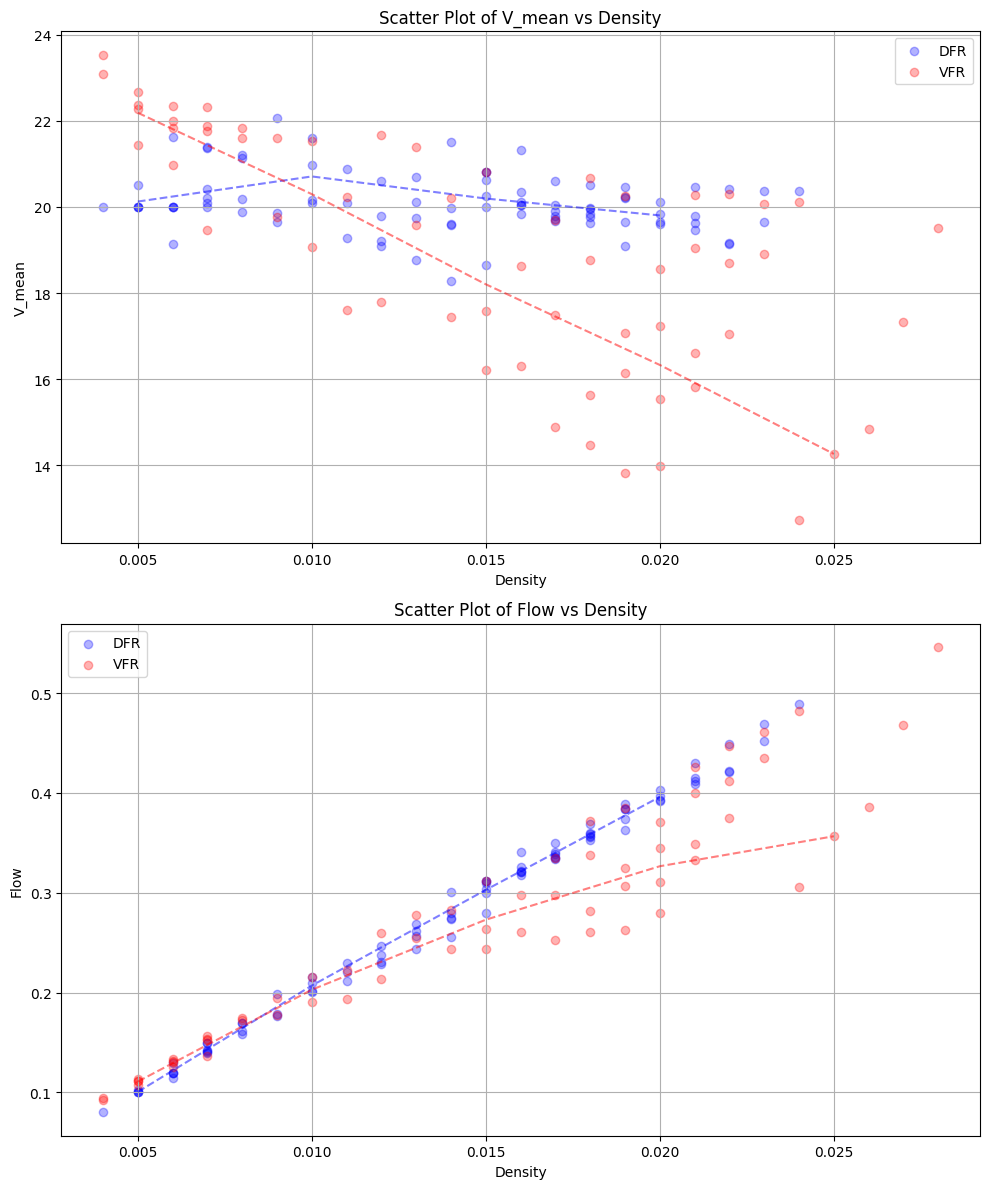

In [70]:
dfr_data = {'density': [], 'v_mean': [], 'flow': []}
vfr_data = {'density': [], 'v_mean': [], 'flow': []}

# 各densityに対するv_meanの平均を計算するための辞書
dfr_density_v_mean = defaultdict(list)
vfr_density_v_mean = defaultdict(list)

for entry in results:
    if entry['v_mean'] is not None:
        for density, v_mean in entry['v_mean'].items():
            if entry['type'] == 'dfr':
                dfr_data['density'].append(density)
                dfr_data['v_mean'].append(v_mean)
                dfr_data['flow'].append(density * v_mean)
                dfr_density_v_mean[density].append(v_mean)
            elif entry['type'] == 'vfr':
                vfr_data['density'].append(density)
                vfr_data['v_mean'].append(v_mean)
                vfr_data['flow'].append(density * v_mean)
                vfr_density_v_mean[density].append(v_mean)

plot_densities = [0.005, 0.010, 0.015, 0.020, 0.025]

# 各指定されたdensityごとのv_meanとflowの平均を計算
dfr_density_avg_v_mean = {density: np.mean(dfr_density_v_mean[density]) for density in plot_densities if density in dfr_density_v_mean}
vfr_density_avg_v_mean = {density: np.mean(vfr_density_v_mean[density]) for density in plot_densities if density in vfr_density_v_mean}

dfr_density_avg_flow = {density: density * np.mean(dfr_density_v_mean[density]) for density in plot_densities if density in dfr_density_v_mean}
vfr_density_avg_flow = {density: density * np.mean(vfr_density_v_mean[density]) for density in plot_densities if density in vfr_density_v_mean}


# ソートしてリスト化
dfr_density_sorted_v_mean = sorted(dfr_density_avg_v_mean.items())
vfr_density_sorted_v_mean = sorted(vfr_density_avg_v_mean.items())

dfr_density_sorted_flow = sorted(dfr_density_avg_flow.items())
vfr_density_sorted_flow = sorted(vfr_density_avg_flow.items())

# プロット
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# v_mean vs density
axs[0].scatter(dfr_data['density'], dfr_data['v_mean'], color='blue', label='DFR', alpha=0.3)
axs[0].scatter(vfr_data['density'], vfr_data['v_mean'], color='red', label='VFR', alpha=0.3)

# 平均線を引く
axs[0].plot([item[0] for item in dfr_density_sorted_v_mean], [item[1] for item in dfr_density_sorted_v_mean], color='blue', linestyle='--', alpha=0.5)
axs[0].plot([item[0] for item in vfr_density_sorted_v_mean], [item[1] for item in vfr_density_sorted_v_mean], color='red', linestyle='--', alpha=0.5)


axs[0].set_xlabel('Density')
axs[0].set_ylabel('V_mean')
axs[0].set_title('Scatter Plot of V_mean vs Density')
axs[0].legend()
axs[0].grid(True)

# flow vs density
axs[1].scatter(dfr_data['density'], dfr_data['flow'], color='blue', label='DFR', alpha=0.3)
axs[1].scatter(vfr_data['density'], vfr_data['flow'], color='red', label='VFR', alpha=0.3)

# 平均線を引く
axs[1].plot([item[0] for item in dfr_density_sorted_flow], [item[1] for item in dfr_density_sorted_flow], color='blue', linestyle='--', alpha=0.5)
axs[1].plot([item[0] for item in vfr_density_sorted_flow], [item[1] for item in vfr_density_sorted_flow], color='red', linestyle='--', alpha=0.5)


axs[1].set_xlabel('Density')
axs[1].set_ylabel('Flow')
axs[1].set_title('Scatter Plot of Flow vs Density')
axs[1].legend()
axs[1].grid(True)

# グラフを表示
plt.tight_layout()
plt.show()

In [15]:
from collections import defaultdict

data = results[0]["v_mean"]
# densityごとにデータをグループ化
density_groups = defaultdict(list)
for entry in data:
    density_groups[entry['density']].append(entry['v_mean'])

# 各densityのv_meanの平均を計算
density_mean_v_mean = {density: sum(v_means)/len(v_means) for density, v_means in density_groups.items()}

print(density_mean_v_mean)

{0.018: 20.484771825396827, 0.017: 19.699868697478987, 0.016: 21.25565476190475, 0.015: 21.408666666666655, 0.014: 20.885714285714275, 0.013: 20.38461538461538, 0.012: 20.00185185185185}


In [16]:
vlog = simulation.v_mean_log
print(vlog[300:340])
table = simulation.reservation_table.eta_table
print(table[table["car_idx"] == 0])

[{'time': 33.0, 'v_mean': 20.04736842105263, 'density': 0.019, 'event_flg': None}, {'time': 33.1, 'v_mean': 20.031578947368423, 'density': 0.019, 'event_flg': None}, {'time': 33.2, 'v_mean': 20.01578947368421, 'density': 0.019, 'event_flg': None}, {'time': 33.300000000000004, 'v_mean': 20.0, 'density': 0.019, 'event_flg': None}, {'time': 33.4, 'v_mean': 19.98421052631579, 'density': 0.019, 'event_flg': None}, {'time': 33.5, 'v_mean': 19.968421052631577, 'density': 0.019, 'event_flg': None}, {'time': 33.6, 'v_mean': 19.95263157894737, 'density': 0.019, 'event_flg': None}, {'time': 33.7, 'v_mean': 19.936842105263157, 'density': 0.019, 'event_flg': None}, {'time': 33.800000000000004, 'v_mean': 19.92105263157895, 'density': 0.019, 'event_flg': None}, {'time': 33.9, 'v_mean': 19.905263157894737, 'density': 0.019, 'event_flg': None}, {'time': 34.0, 'v_mean': 19.905263157894737, 'density': 0.019, 'event_flg': None}, {'time': 34.1, 'v_mean': 19.905263157894737, 'density': 0.019, 'event_flg': N

[20.300000000000004, 20.599999999999994, 20.9, 21.20000000000001, 21.500000000000004, 21.800000000000015, 22.10000000000001, 22.40000000000002, 22.699999999999996, 23.000000000000007, 23.30000000000002, 23.599999999999994, 23.900000000000006, 24.200000000000017, 24.499999999999993, 24.80000000000004, 24.933763884510753, 25.00205455537177, 25.045066351248195, 25.078284478181345, 25.107649150798323, 25.13543427568102, 25.162509497197192, 25.189207542893186, 25.21565612084416, 25.241904739377077, 25.26797310634123, 25.29386957926704, 25.319598191088915, 25.34516132271463, 25.37056071867525, 25.39579787278342, 25.420874174509436, 25.44579096457028, 25.470549556103492, 25.49515124281058, 25.51959730216808, 25.54388899677207, 25.568027574976497, 25.592014271262684, 25.615850306503347, 25.639536888187706, 25.66307521062626, 25.686466455148178, 25.709711790291863, 25.73281237199282, 26.032812371992833, 26.332812371992844, 26.632812371992856, 26.932812371992867, 27.23281237199288, 27.5328123719

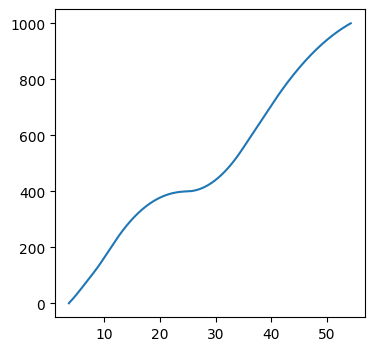

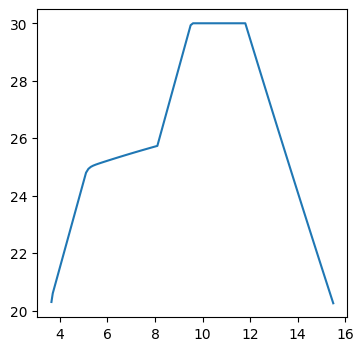

In [15]:
cars = vfr_simulation.CARS
car_0 = cars[1]
xcors = car_0.xcorList
plt.figure(figsize = (4,4))
plt.plot(car_0.timeLog, car_0.xcorList)

vList = []
for i in range(len(xcors)-1):
    v = (xcors[i+1] - xcors[i]) * 10
    vList.append(v)

print(vList[:120])

plt.figure(figsize=(4,4))
plt.plot(car_0.timeLog[:120], vList[:120])



In [13]:
# 動画作成
import cv2
import os
import re

# カレントディレクトリを取得
current_dir = os.getcwd()
# 画像フォルダのパス
image_folder = os.path.join(current_dir, 'images')
video_file = f'output_video_TTC={TTC}.mp4'

# 正規表現でファイル名からtの値を抽出
def extract_t(filename):
    match = re.search(r't=(\d+\.\d+)', filename)
    if match:
        return float(match.group(1))
    return None

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images = sorted(images, key=lambda x: extract_t(x))

# 画像から動画を作成
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

# 動画ライターを設定
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(video_file, fourcc, 5, (width, height))  # フレームレートを5fpsに設定

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

# リソースを解放
cv2.destroyAllWindows()
video.release()

# ここから下はDebug用のセル

In [27]:
# ↑の DFRのシミュレーションでつっかえた時のデバッグ用のセル. これは適宜上に上げて良い

car_1 = CARS[14]
print("ETA",car_1.my_etas)
print("===  acc_itinerary =====")
print(car_1.acc_itinerary)
print(car_1.xcor)
print(car_1.v_x)

# print("acc:",car.acc_itinerary)
# table = simulation.reservation_table.eta_table
# print(table[table["car_idx"]<=4])

IndexError: list index out of range

In [7]:
import sys 
sys.path.append("../")
from utils.calc_distance_from_acc_itinerary import calc_distance_from_acc_itinerary
acc_itinerary = [{'acc': 0, 't_start': 29.113823476836664, 'v_0': 20, 't_end': 32.6, 'x_start': 0}, {'t_start': 32.6, 'acc': -3, 'v_0': 20.0, 't_end': 33.1}, {'t_start': 33.1, 'acc': 0, 'v_0': 18.5, 't_end': 45.120270270270275}, {'t_start': 45.120270270270275, 'acc': -3, 'v_0': 18.5, 't_end': 45.620270270270275}, {'t_start': 45.620270270270275, 'acc': 0, 'v_0': 17.0, 't_end': 52.745270270270275}, {'t_start': 52.745270270270275, 'acc': 2, 'v_0': 17.0, 't_end': 53.745270270270275}, {'t_start': 53.745270270270275, 'acc': 0, 'v_0': 19.0, 't_end': 56.804093799682036}, {'t_start': 56.804093799682036, 'acc': 2, 'v_0': 19.0, 't_end': 60.804093799682036}, {'t_start': 60.804093799682036, 'acc': 0, 'v_0': 27.0, 't_end': 60.90316500711238}]
x = calc_distance_from_acc_itinerary(acc_itinerary, 53)
print(x)

436.1188231038803


In [6]:
def calc_x_at_pointed_time(pointed_time, carObj, current_time):
    acc_itinerary = carObj.acc_itinerary
    car_x = carObj.xcor
    # print(carObj.xcor, carObj.acc_itinerary)
    v_0 = carObj.v_x
    acc_itinerary_with_tend = carObj.acc_itinerary
    # print(f"carId: {carObj.car_idx}, acc_itinerary: {acc_itinerary_with_tend}")

    if len(acc_itinerary_with_tend) < 1:
        raise ValueError("acc_itinerary is empty")
    if len(acc_itinerary_with_tend) == 1:
        delta_t = pointed_time - current_time
        delta_x = v_0 * delta_t + 0.5 * acc_itinerary_with_tend[0]["acc"] * delta_t**2 + car_x
        return delta_x
    
    # 長さ2以上の場合
    for idx, accObj in enumerate(acc_itinerary_with_tend):
        if accObj["t_end"] < current_time:
            continue

        # この区間を全うできる場合.
        elif accObj["t_end"] <= pointed_time:
            delta_t = accObj["t_end"] - accObj["t_start"]
            if accObj["t_start"] < current_time:
                delta_t = accObj["t_end"] - current_time
            delta_x = v_0 * delta_t + 0.5 * accObj["acc"] * delta_t**2
            car_x += delta_x
            v_0 += delta_t * accObj["acc"]

        # 一番最後の区間の場合
        elif idx == len(acc_itinerary) - 1 or accObj["t_end"] > pointed_time:
            delta_t = pointed_time - accObj["t_start"]
            if accObj["t_start"] < current_time:
                delta_t = accObj["t_end"] - current_time
            delta_x = v_0 * delta_t + 0.5 * accObj["acc"] * delta_t**2
            car_x += delta_x
            break
        else:
            print(accObj, current_time, pointed_time, carObj.car_idx)
            raise ValueError("Something wrong")

    return car_x

calc_x_at_pointed_time(53, car_1, 48)

442.42488723520705